# Bank Churn Prediction

In [1]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
import os
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("dark") # Theme for plots as Dark
sns.set_palette("viridis")
# sns.color_palette("flare")
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
import optuna
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from catboost import Pool, CatBoostClassifier, cv
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
from sklearn.cluster import KMeans

# Data Overview

In [33]:
train_df= pd.read_csv("/kaggle/input/playground-series-s4e1/train.csv",index_col="id")
test = pd.read_csv("/kaggle/input/playground-series-s4e1/test.csv",index_col="id")
orig = pd.read_csv('/kaggle/input/churn-prediction-of-bank-customers/Churn_Modelling.csv',index_col = "RowNumber")
orig.dropna(inplace=True)

train_df= pd.concat([train_data,orig_data])
train_df.reset_index(drop=True,inplace=True)

In [34]:
train_df.head(3)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.0,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.0,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.0,2,1.0,0.0,184866.69,0


# Data Preprocessing

In [35]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
encoder = LabelEncoder()
train_df['Gender'] = encoder.fit_transform(train_df['Gender'])
train_df['Geography'] = encoder.fit_transform(train_df['Geography'])

test['Gender'] = encoder.fit_transform(test['Gender'])
test['Geography'] = encoder.fit_transform(test['Geography'])

In [36]:
train_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,Okwudilichukwu,668,0,1,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,0,1,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,0,1,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,0,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [37]:
train_df.shape

(185034, 13)

In [38]:
train_df.drop(['Surname'],axis=1,inplace=True)
test.drop(['Surname'],axis=1,inplace=True)

In [39]:
test.isnull().sum()

CustomerId         0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [40]:
N_CLUSTERS = 6
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0, n_init="auto")

clusters_train = kmeans.fit_predict(train_df.drop(["Exited"],axis=1))
clusters_test = kmeans.predict(test)

train_df["cluster"] = clusters_train
test["cluster"] = clusters_test

In [41]:
train_df.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,cluster
0,15674932,668,0,1,33.0,3,0.00,2,1.0,0.0,181449.97,0,4
1,15749177,627,0,1,33.0,1,0.00,2,1.0,1.0,49503.50,0,2
2,15694510,678,0,1,40.0,10,0.00,2,1.0,0.0,184866.69,0,4
3,15741417,581,0,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0
4,15766172,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83,0,2


# Data Visualization

<Axes: >

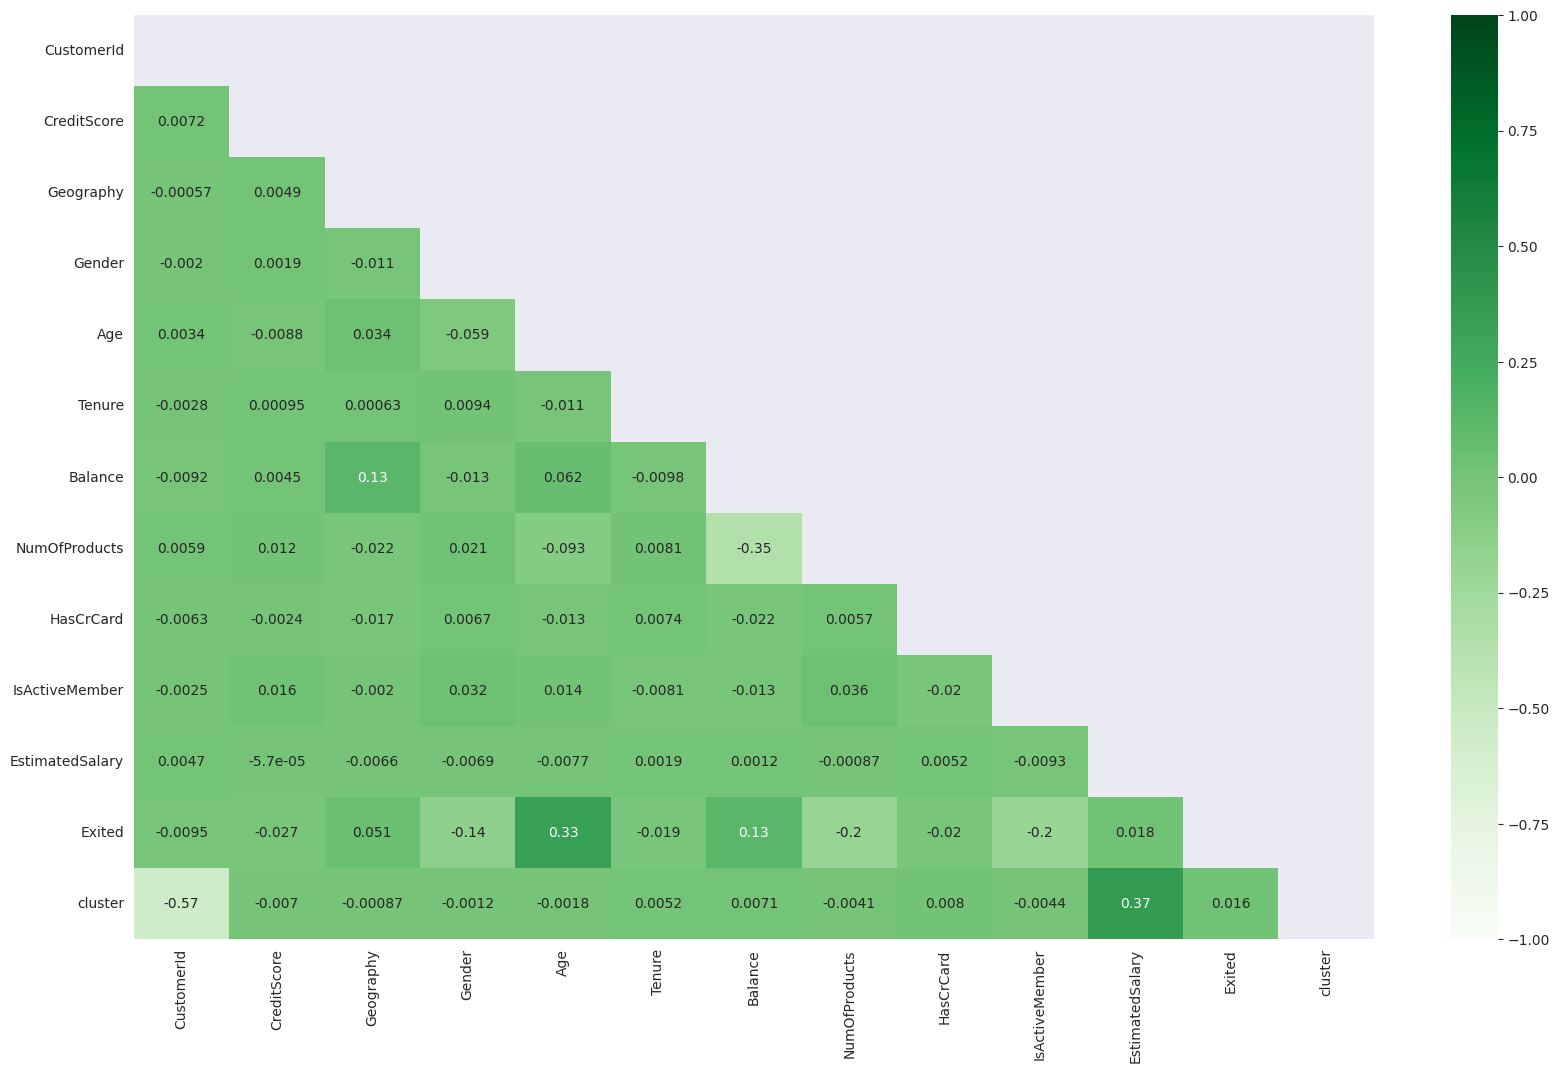

In [46]:
mask = np.triu(np.ones_like(train_df.corr()))
plt.figure(figsize=(20,12))
sns.heatmap(train_df.corr(),cmap='Greens',annot=True, mask = mask, vmin=-1,vmax=1)

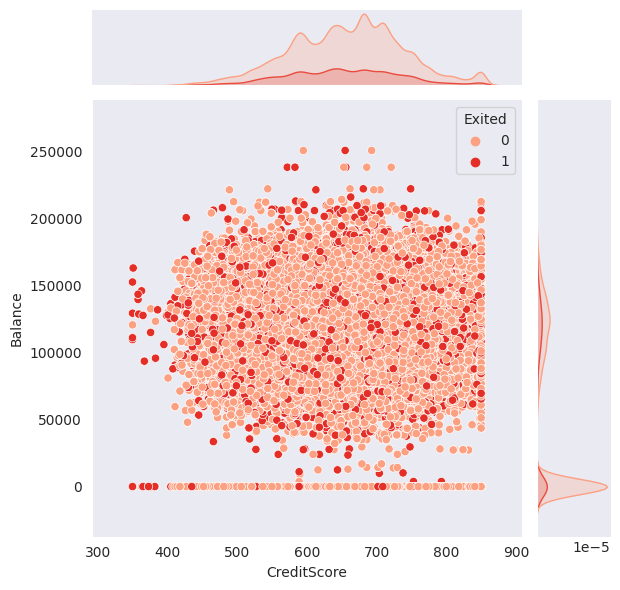

In [52]:
sns.jointplot(data=train_df,x = 'CreditScore',y = 'Balance',hue='Exited',palette='Reds')

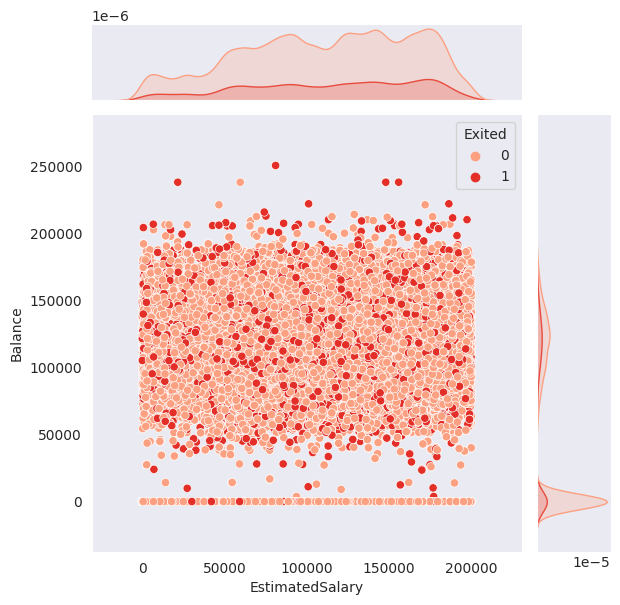

In [53]:
sns.jointplot(data=train_df,x = 'EstimatedSalary',y = 'Balance',hue='Exited',palette='Reds')

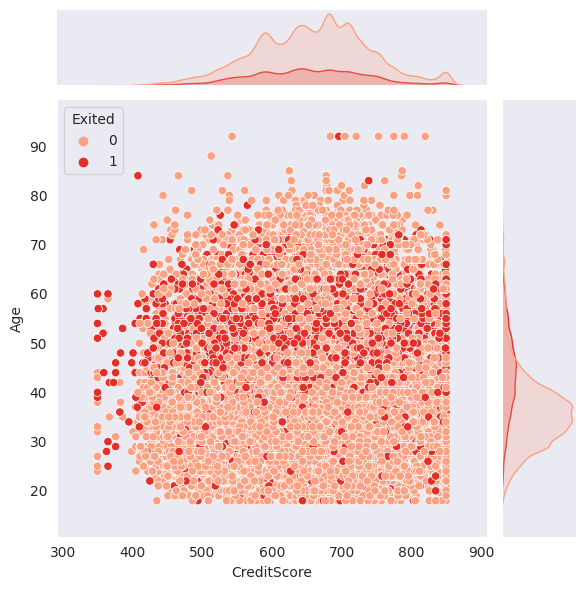

In [54]:
sns.jointplot(data=train_df,x = 'CreditScore',y = 'Age',hue='Exited',palette='Reds')

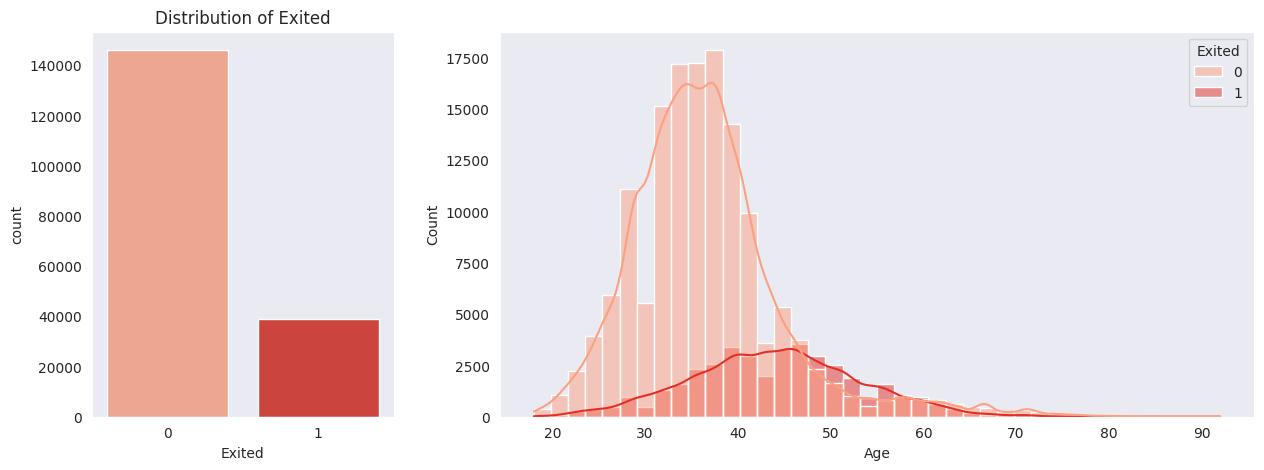

In [57]:
fig,axes = plt.subplots(1,2,figsize=(15,5), gridspec_kw={'width_ratios':[1,2.5]})

plt.subplot(1,2,1)
sns.countplot(data=train_df,x = 'Exited',palette='Reds')
plt.title('Distribution of Exited')
    
plt.subplot(1,2,2)
sns.histplot(data=train_df,x='Age',hue='Exited',bins=40,kde=True,palette='Reds')

fig.show()

In [58]:
clust = list(dict(sorted(Counter(clusters_test).items(), key=lambda item: item[0])).values())
clust.extend(list(dict(sorted(Counter(clusters_train).items(),key = lambda item:item[0])).values()))

clusters = pd.DataFrame()
clusters['clusters_type'] = ['test']*N_cluster + ['train']*N_cluster
clusters['Cluster_label'] = list(range(0,N_cluster))*2
clusters['No Of Items'] = clust

Text(0.5, 1.0, 'Kmeans Clusters of the train and test data')

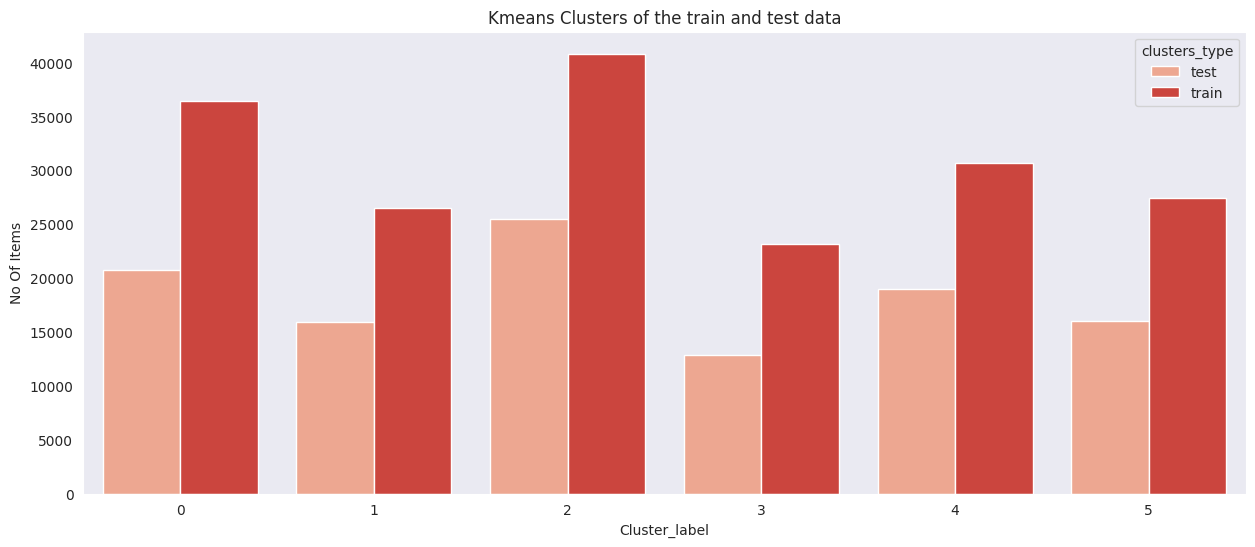

In [59]:
plt.figure(figsize=(15,6))
sns.barplot(clusters,x='Cluster_label',y='No Of Items', hue = 'clusters_type',palette = 'Reds')
plt.title('Kmeans Clusters of the train and test data')

In [63]:
clusters['No of Exited'] = 0
clusters['No of Exited'][clusters['clusters_type']=='train'] = list(dict(sorted(Counter(train_df[train_df['Exited']==1].cluster).items(),key=lambda item:item[0])).values())
clusters['Ratio of Exited'] = clusters['No of Exited']  / clusters['No Of Items']

<Axes: xlabel='Cluster_label', ylabel='Ratio of Exited'>

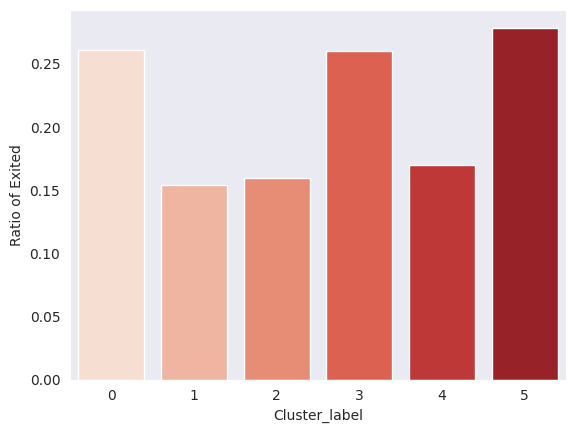

In [64]:
sns.barplot(data=clusters.query("clusters_type == 'train'"),y='Ratio of Exited', x = "Cluster_label",palette="Reds")

# Training Model

In [65]:
train_df.head(1)

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,cluster
0,15674932,668,0,1,33.0,3,0.0,2,1.0,0.0,181449.97,0,4


In [66]:
seed = np.random.seed(6)

x = train_df.drop(['CustomerId','Exited'],axis=1)
y = train_df['Exited']

xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=.2)

In [67]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.fit_transform(xtest)

In [71]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

# Assuming xtrain, ytrain, xtest, ytest are defined

seed = 42  # Replace with your desired random seed
lgbmodel = LGBMClassifier(random_state=seed)
lgbmodel.fit(xtrain, ytrain)

print('CV score of lgb', cross_val_score(lgbmodel, xtrain, ytrain, cv=5, scoring='roc_auc').mean())

# Assuming lgbmodel.predict_proba() returns probabilities for the positive class
ytest_probabilities = lgbmodel.predict_proba(xtest)[:, 1]

print("ROC AUC over val data", roc_auc_score(ytest, ytest_probabilities))


CV score of lgb 0.8877090231780318
ROC AUC over val data 0.8856605644943527


In [73]:
xgbmodel = XGBClassifier(random_state=seed)
xgbmodel.fit(xtrain, ytrain)

print('CV score of lgb', cross_val_score(xgbmodel, xtrain, ytrain, cv=5, scoring='roc_auc').mean())


ytest_probabilities = xgbmodel.predict_proba(xtest)[:, 1]

print("ROC AUC over val data", roc_auc_score(ytest, ytest_probabilities))


CV score of lgb 0.8860422829729924
ROC AUC over val data 0.7239889420413597


In [74]:
ranmodel = RandomForestClassifier(random_state=seed)
ranmodel.fit(xtrain, ytrain)

print('CV score of lgb', cross_val_score(ranmodel, xtrain, ytrain, cv=5, scoring='roc_auc').mean())


ytest_probabilities = ranmodel.predict_proba(xtest)[:, 1]

print("ROC AUC over val data", roc_auc_score(ytest, ytest_probabilities))


CV score of lgb 0.8809946185987563
ROC AUC over val data 0.8855385577232343


In [77]:
test.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,cluster
id,,,,,,,,,,,
165034,586,0,0,23.0,2,0.00,2,0.0,1.0,160976.75,2
165035,683,0,0,46.0,2,0.00,1,1.0,0.0,72549.27,2
165036,656,0,0,34.0,7,0.00,2,1.0,0.0,138882.09,2
165037,681,0,1,36.0,8,0.00,1,1.0,0.0,113931.57,2
165038,752,1,1,38.0,10,121263.62,1,1.0,0.0,139431.00,5


# Creating More Training Data

In [79]:
for i in range(10):
    print(f'> Generating{i}')
    print(f" Inital Train Size:{train_df} -->",end='')
    
    X = train_df.drop(['CustomerId','Exited'],axis=1)
    y = train_df['Exited']
#     test.drop(['id'],axis=1,inplace=True)
    lgbmodel.fit(X,y)
    xgbmodel.fit(X,y)
    
    more_train  = test.copy()
    more_train['Exited'] = (lgbmodel.predict_proba(test)[:,1]+xgbmodel.predict_proba(test)[:,1])/2
    more_train = more_train.query('Exited>0.96 | Exited<0.4')
    more_train['Exited'] = round(more_train['Exited'])
    more_train['Exited'] = more_train['Exited'].astype('int64')
    
    train_df = pd.concat([train_df, more_train])
    train_df.drop_duplicates(inplace=True)
    train_df.reset_index(inplace=True,drop=True)
    train_df = train_df.sample(frac=1)
    print(f" Final Train Size: {len(train_df)}\n")
    

> Generating0
 Inital Train Size:        CustomerId  CreditScore  Geography  Gender   Age  Tenure    Balance  \
139488  15763859.0          773          2       0  40.0       9       0.00   
247706         NaN          695          0       0  33.0       2       0.00   
203816         NaN          556          0       0  22.0       4       0.00   
73685   15793949.0          696          1       0  39.0       8   72664.00   
237356         NaN          540          1       0  33.0       1   87347.70   
...            ...          ...        ...     ...   ...     ...        ...   
158596  15747458.0          716          0       0  25.0       5       0.00   
110295  15681274.0          595          0       1  33.0       2       0.00   
30922   15682355.0          710          0       0  42.0      10  138053.97   
91729   15772383.0          471          0       0  40.0       2       0.00   
25178   15664504.0          583          2       1  52.0       4  141806.00   

        NumOfProdu


# Out Of Fold Predictions LGB + Cat + XGB

In [80]:
submission = pd.DataFrame()
submission["id"] = test_data.index
submission["Exited"] = 0

In [81]:
SPLITS = 5
REPEATS = 2
lgb_auc_scores = []
cat_auc_scores =[]
xgb_auc_socres =

In [103]:
for i,(tr,val) in enumerate(RepeatedStratifiedKFold(n_splits=SPLITS, n_repeats=REPEATS,random_state=seed).split(X,y)):
    
    print("-"*30,f"FOLD {i+1}/{SPLITS*REPEATS}","-"*30)
    X_train, X_test, y_train, y_test = X.iloc[tr,:],X.iloc[val,:],y.iloc[tr],y.iloc[val]
    
    print("\n->","LGBM:")
    lgbmmodel = LGBMClassifier(n_estimators= 5000,random_state=seed)
    lgbmmodel.fit(X_train,y_train, eval_set=[(X_test,y_test)], eval_names=["valid"],eval_metric=['auc'], early_stopping_rounds=1000,verbose = 1000)
    auc = roc_auc_score(y_test, lgbmmodel.predict_proba(X_test)[:,1])
    lgb_auc_scores.append(auc)
    print(f"\nFold {i+1} ROC_AUC of LGBM =", auc,"\n")
    submission["Exited"] += lgbmmodel.predict_proba(test)[:,1]
    
    print("\n->","CAT:")
    train_df = Pool(data=X.iloc[tr,:],label=y.iloc[tr])
    eval_dataset = Pool(data=X.iloc[val,:],label=y.iloc[val])
    
    catmodel = CatBoostClassifier(iterations=5000,verbose=1000, od_type="Iter",eval_metric="AUC", random_seed=seed,early_stopping_rounds=500)
    catmodel.fit(train_df, use_best_model=True, eval_set=eval_dataset)
    auc = roc_auc_score(y.iloc[val], catmodel.predict_proba(X.iloc[val,:])[:,1])
    cat_auc_scores.append(auc)
    submission["Exited"] += catmodel.predict_proba(test)[:,1]
    
    print("\n->","XGB:")
    xgbmodel = XGBClassifier(n_estimators= 5000,random_state=seed,eval_metric="auc",early_stopping_rounds = 1000)
    xgbmodel.fit(X_train,y_train, eval_set=[(X_test,y_test)],verbose = 1000,callbacks=[EarlyStopping(rounds = 1000,save_best=True)])
    auc = roc_auc_score(y_test, xgbmodel.predict_proba(X_test)[:,1])
    xgb_auc_socres.append(auc)
    print(f"\nFold {i+1} ROC_AUC of XGB =", auc)
    submission["Exited"] += xgbmodel.predict_proba(test)[:,1]
    
print("\n\n","-"*50,sep="")
print("CV score of LGBM is ",np.array(lgb_auc_scores).mean())
print("CV score of CAT is ",np.array(cat_auc_scores).mean())
print("CV score of XGB is ",np.array(xgb_auc_socres).mean())

------------------------------ FOLD 1/10 ------------------------------

-> LGBM:
[1000]	valid's auc: 0.890325	valid's binary_logloss: 0.248739

Fold 1 ROC_AUC of LGBM = 0.8937646400442435 


-> CAT:
Learning rate set to 0.059331
0:	test: 0.8559761	best: 0.8559761 (0)	total: 37.4ms	remaining: 3m 7s
1000:	test: 0.8937517	best: 0.8941948 (513)	total: 35.6s	remaining: 2m 22s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8941948331
bestIteration = 513

Shrink model to first 514 iterations.

-> XGB:
[0]	validation_0-auc:0.87737
[1000]	validation_0-auc:0.87041
[1026]	validation_0-auc:0.87010

Fold 1 ROC_AUC of XGB = 0.893222998858817
------------------------------ FOLD 2/10 ------------------------------

-> LGBM:
[1000]	valid's auc: 0.889453	valid's binary_logloss: 0.248414

Fold 2 ROC_AUC of LGBM = 0.8937165717556487 


-> CAT:
Learning rate set to 0.059331
0:	test: 0.8550355	best: 0.8550355 (0)	total: 36.3ms	remaining: 3m 1s
Stopped by overfitting detector  (500 ite

In [104]:
submission["Exited"] = submission["Exited"]/(SPLITS*REPEATS*3)

submission.to_csv("submission.csv",header=True,index=False)
submission

,id,Exited
0,165034,0.017322
1,165035,0.981819
2,165036,0.017839
3,165037,0.150216
4,165038,0.281655
...,...,...
110018,275052,0.030770
110019,275053,0.122726
110020,275054,0.011986
110021,275055,0.105443


# Building ANN

In [105]:
from keras.models import Sequential
from keras.layers import Dense,Dropout, BatchNormalization
from keras.optimizers import Adam
import tensorflow
from keras import regularizers

In [112]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

def build_model(hp):
    model = keras.Sequential()

    # Add an input layer
    model.add(layers.Dense(units=hp.Int('units_input', min_value=32, max_value=512, step=32),
                           input_dim=X_train.shape[1],
                           activation=hp.Choice('activation_input', values=['relu', 'tanh'])))
    model.add(layers.Dropout(rate=hp.Float('dropout_input', min_value=0.2, max_value=0.5, step=0.1)))

    # Add hidden layers
    for i in range(hp.Int('num_layers', min_value=1, max_value=8)):
        model.add(layers.Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
                               activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh'])))
        model.add(layers.Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [113]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [114]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='mydir',
    project_name='churn_tune'
)

In [115]:
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Trial 10 Complete [00h 04m 25s]
val_accuracy: 0.859066903591156

Best val_accuracy So Far: 0.859066903591156
Total elapsed time: 00h 38m 11s


In [116]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


In [117]:
best_model = tuner.hypermodel.build(best_hps)

In [118]:
history1 = best_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test),callbacks = early_stopping)

Epoch 1/50
6739/6739 [==============================] - 47s 7ms/step - loss: 0.4090 - accuracy: 0.8585 - val_loss: 0.4105 - val_accuracy: 0.8591
Epoch 2/50
6739/6739 [==============================] - 44s 6ms/step - loss: 0.4074 - accuracy: 0.8591 - val_loss: 0.4067 - val_accuracy: 0.8591
Epoch 3/50
6739/6739 [==============================] - 44s 7ms/step - loss: 0.4074 - accuracy: 0.8591 - val_loss: 0.4068 - val_accuracy: 0.8591
Epoch 4/50
6739/6739 [==============================] - 44s 7ms/step - loss: 0.4071 - accuracy: 0.8591 - val_loss: 0.4070 - val_accuracy: 0.8591
Epoch 5/50
6739/6739 [==============================] - 44s 6ms/step - loss: 0.4072 - accuracy: 0.8591 - val_loss: 0.4067 - val_accuracy: 0.8591
Epoch 6/50
6739/6739 [==============================] - 44s 7ms/step - loss: 0.4072 - accuracy: 0.8591 - val_loss: 0.4073 - val_accuracy: 0.8591
Epoch 7/50
6739/6739 [==============================] - 44s 7ms/step - loss: 0.4072 - accuracy: 0.8591 - val_loss: 0.4068 - val_ac

In [119]:
best_model.evaluate(X_test,y_test)

1685/1685 [==============================] - 3s 2ms/step - loss: 0.4067 - accuracy: 0.8591


[0.4066784381866455, 0.859066903591156]